A.S. Lundervold, v. 25.10.22

# Introduction

As we've learned, deep neural networks provide (at least partly) hierarchical representations of data that are tailored to a given task. 

<img src="https://upload.wikimedia.org/wikipedia/en/8/83/VGG_neural_network.png">

At the end of a high-performance deep neural network, i.e., in the later hidden layers, you'll find a representation for each data instance that makes the task (relatively) easy to solve. 

An idea that can be quite useful in a wide variety of tasks is to _extract_ these representations and use them in other ML models. This is one easy way to combine information extracted by a deep neural network with other useful information for the task at hand. 

We'll use this idea in this notebook by extracting vector representations from the last hidden layer of a trained CNN to train other ML models.

We'll do that by using so-called PyTorch **hooks**.

## Hooks in PyTorch

Remember that neural networks are **computational graphs**

![](https://docs.chainer.org/en/latest/_images/googlenet.png)<br>
<center><small>Illustration from <a href="https://docs.chainer.org/en/stable/">https://docs.chainer.org/en/stable/</a> </small></center>

- Hooks are functions injected into these computational graphs by attaching them to tensors or to modules (network layers)
- This allows us to access and modify gradients associated with tensors and the inputs and outputs of layers (modules) as they flow through the computational graphs
- We can attach backward and forward hooks to modules: triggered during backward and forward calculations, respectively.

> In this notebook, we'll attach a hook to the final linear layer of the model to grab the activations before they are passed to the final classification layers. These activations will be a task-specific representation of the data. 

The PyTorch docs have a description of hooks here: https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks. See also the Paperspace blog post: https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/. Here's a video tutorial that explains hooks in quite some detail: https://www.youtube.com/watch?v=syLFCVYua6Q. 

# Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
torch.cuda.get_device_name(0)

'NVIDIA TITAN V'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import pandas as pd

In [3]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory, as that makes some difference for the code below.
# We'll do this in every notebook of the course.
if 'google.colab' in str(get_ipython()):
    print('The notebook is running on Colab. colab=True.')
    colab=True
else:
    print('The notebook is not running on Colab. colab=False.')
    colab=False

The notebook is not running on Colab. colab=False.


In [4]:
if colab:
    !pip install -Uqq fastbook
    !pip install -Uqq fastaudio
    import fastbook
    fastbook.setup_book()
    from fastbook import *
    from fastai.vision.all import *
    NB_DIR = Path.cwd()
else:
    from fastai.vision.all import *
    NB_DIR = Path.cwd()
    DATA = Path('/data2/alex/pcs-data')  # Set this to where you've stored data  
    
if colab:
    DATA = Path('./gdrive/MyDrive/ColabData')
    DATA.mkdir(exist_ok=True)

In [5]:
NB_DIR = Path.cwd()

# Image data will be stored here
IMGDATA = Path.home()/'pcs-data'/'specimages'
IMGDATA.mkdir(exist_ok=True, parents=True)

# Load data

We'll use the same data set that we studied in notebook `2.2.0-asl-`: the ECS-50 sound classification data set.

In [6]:
path = DATA/'master'
path.ls()

(#11) [Path('/data2/alex/pcs-data/master/audio'),Path('/data2/alex/pcs-data/master/meta'),Path('/data2/alex/pcs-data/master/LICENSE'),Path('/data2/alex/pcs-data/master/.circleci'),Path('/data2/alex/pcs-data/master/.github'),Path('/data2/alex/pcs-data/master/.gitignore'),Path('/data2/alex/pcs-data/master/pytest.ini'),Path('/data2/alex/pcs-data/master/esc50.gif'),Path('/data2/alex/pcs-data/master/requirements.txt'),Path('/data2/alex/pcs-data/master/tests')...]

In [7]:
audio_files = (path/'audio').ls()

In [8]:
audio_files

(#2000) [Path('/data2/alex/pcs-data/master/audio/4-188293-A-15.wav'),Path('/data2/alex/pcs-data/master/audio/4-182368-A-12.wav'),Path('/data2/alex/pcs-data/master/audio/4-194246-A-13.wav'),Path('/data2/alex/pcs-data/master/audio/4-212698-A-39.wav'),Path('/data2/alex/pcs-data/master/audio/5-207836-A-29.wav'),Path('/data2/alex/pcs-data/master/audio/5-263501-A-25.wav'),Path('/data2/alex/pcs-data/master/audio/1-28135-A-11.wav'),Path('/data2/alex/pcs-data/master/audio/2-166644-A-2.wav'),Path('/data2/alex/pcs-data/master/audio/3-203373-A-39.wav'),Path('/data2/alex/pcs-data/master/audio/1-50623-A-15.wav')...]

In [9]:
df = pd.read_csv(path/'meta'/'esc50.csv')

In [10]:
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


# Save spectrograms as images

We'll use librosa through fastaudio to construct the spectrograms.

In [11]:
from fastaudio.core.all import *

/home/ubuntu/anaconda3/envs/fastaudio/lib/python3.9/site-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


In [12]:
sr = 22050

In [13]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512, sample_rate=sr)
a2s = AudioToSpec.from_cfg(cfg)

/home/ubuntu/anaconda3/envs/fastaudio/lib/python3.9/site-packages/torchaudio/functional/functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [14]:
pipeline = Pipeline([AudioTensor.create, a2s])

In [15]:
def get_spec(fn):
    return pipeline(fn)

In [16]:
from librosa.display import specshow

In [17]:
def plot_save_spec(fn,ax=None, save=False):
    img_fn = fn.stem + ".png"
    if not save:
        sg = get_spec(fn)
        f, ax = plt.subplots()
        ax.axis("off")
        z = specshow(
            sg[0].cpu().numpy(), ax=ax, **sg._all_show_args()) 
        return ax
    if save:
        if not os.path.isfile(IMGDATA/img_fn):
            sg = get_spec(fn)
            f, ax = plt.subplots()
            ax.axis("off")
            z = specshow(
                sg[0].cpu().numpy(), ax=ax, **sg._all_show_args())
            plt.savefig(IMGDATA/img_fn) 
            plt.close()
            return ax

<AxesSubplot: xlabel='Time', ylabel='Hz'>

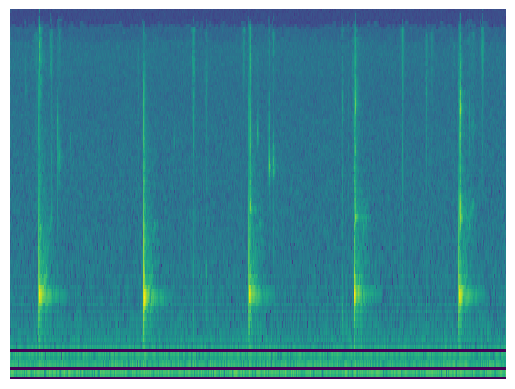

In [18]:
plot_save_spec(audio_files[0], save=False)

In [19]:
for fn in audio_files:
    _ = plot_save_spec(fn, save=True)

Insert image location into data frame:

In [20]:
def get_imgfn(fn):
    fn = fn.split(".")[0] + ".png"
    return fn

In [21]:
df["Image"] = df["filename"].apply(get_imgfn)

In [22]:
df.head()

,filename,fold,target,category,esc10,src_file,take,Image
0,1-100032-A-0.wav,1,0,dog,True,100032,A,1-100032-A-0.png
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,1-100038-A-14.png
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1-100210-A-36.png
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1-100210-B-36.png
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1-101296-A-19.png


# Create a dataloader

In [23]:
bs=64

In [24]:
datablock = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA),
    get_y=ColReader('category'),
    splitter=RandomSplitter(seed=42),
    item_tfms=None,
    batch_tfms=None
    )

In [25]:
dls = datablock.dataloaders(df, bs=bs, shuffle_train=True)

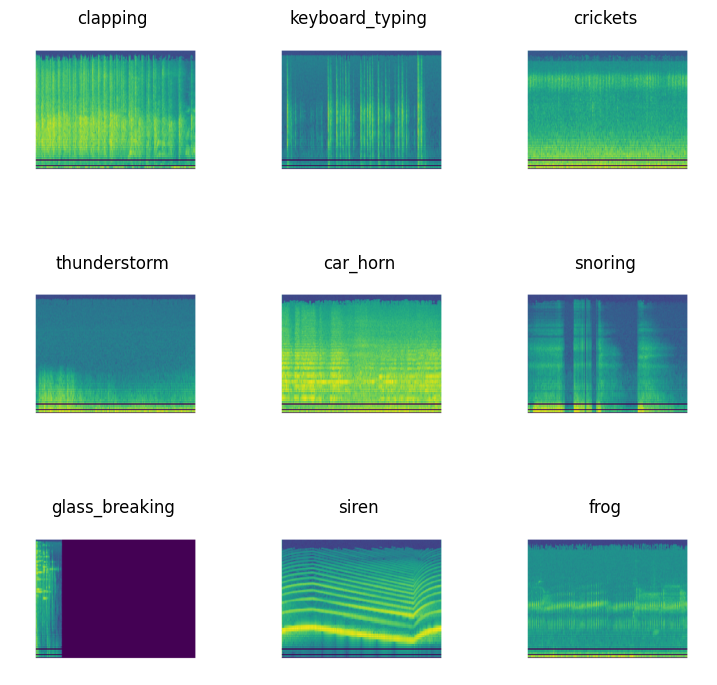

In [26]:
dls.show_batch()

# Train a CNN

We use a pretrained resnet18 model as before, only adding a custom "head" to the model that outputs 128 features (to have fewer activations in the final hidden layer):

In [27]:
resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
custom_head = create_head(nf=512, n_out=50, lin_ftrs=[128], concat_pool=True)

In [29]:
custom_head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=128, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=128, out_features=50, bias=False)
)

In [30]:
learn = cnn_learner(dls,                             
                arch=resnet18, pretrained=True,  
                custom_head=custom_head,
                wd=2e-4, ps=0.8,                    
                metrics=accuracy,
                cbs=[ShowGraphCallback()])

In [31]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

The below training takes a while. We can rather load the results of a previous run:

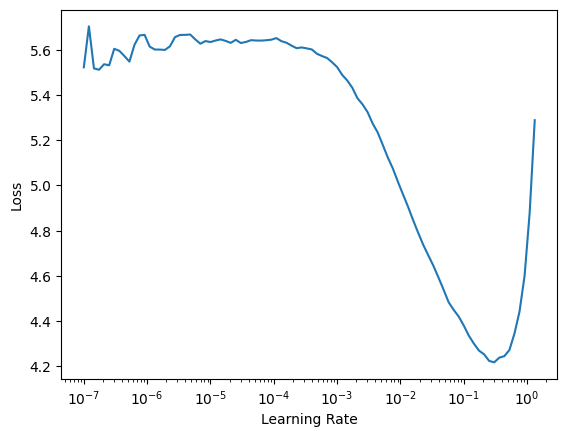

In [32]:
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,3.876870,2.022804,0.455000,00:12


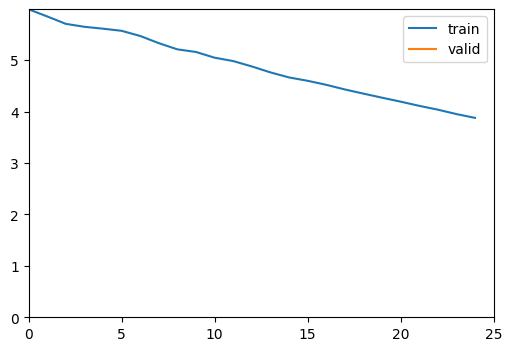

epoch,train_loss,valid_loss,accuracy,time
0,1.945692,1.590512,0.555000,00:15
1,1.581984,1.392598,0.640000,00:14
2,1.200610,0.917122,0.722500,00:14
3,0.849079,0.622684,0.845000,00:14
4,0.589675,0.526383,0.850000,00:14


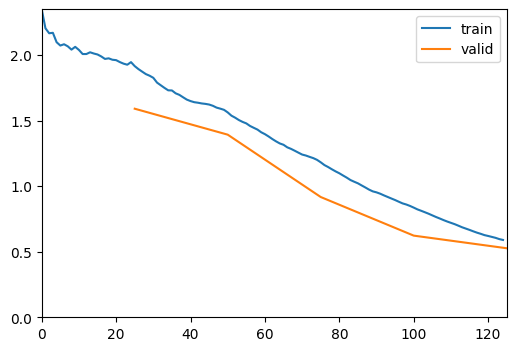

In [33]:
learn.fine_tune(5, lr.lr_steep)

### Evaluate

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

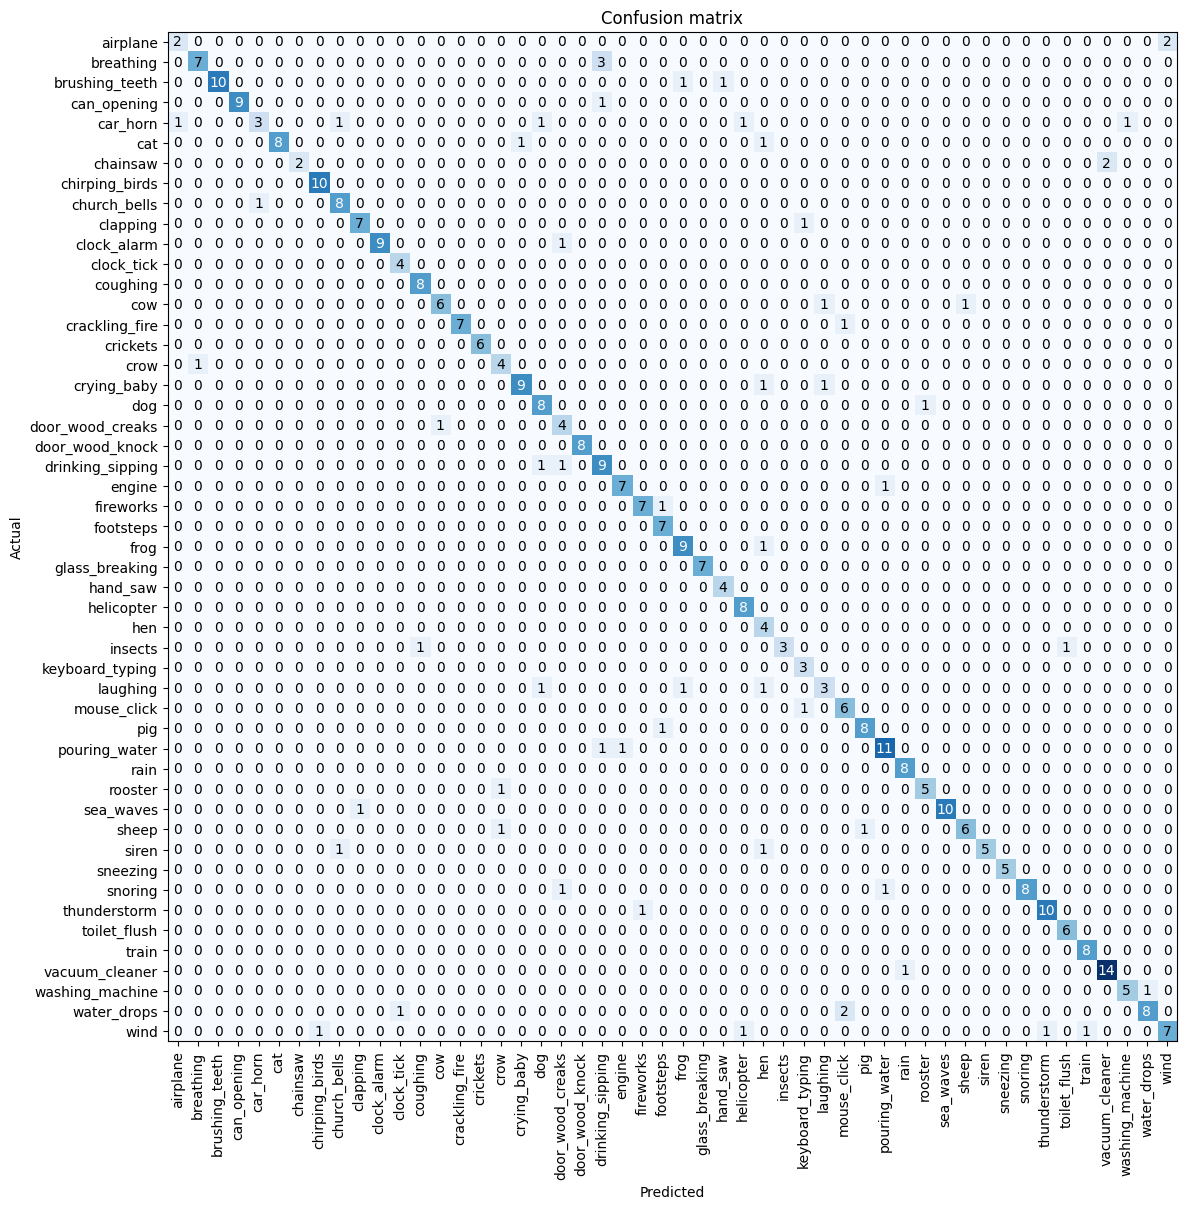

In [35]:
interp.plot_confusion_matrix(figsize=(12,12))

# Save activations 

from second final layer.

We need to register a **forward hook** at the layer we want to save activations from:

In [36]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [37]:
learn.model[-1][-5]

Linear(in_features=1024, out_features=128, bias=False)

In [38]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

No data augmentation:

In [39]:
test_db = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA),
    get_y=ColReader('category'),
    splitter=RandomSplitter(valid_pct=0.),
    item_tfms=None,
    batch_tfms=None
    )

We can feed one image at a time throught the model to get the activations

In [40]:
test_dls = test_db.dataloaders(df, bs=1)

In [41]:
test_df = test_dls.items.reset_index()

In [42]:
test_df.head()

,index,filename,fold,target,category,esc10,src_file,take,Image
0,1511,4-198841-A-37.wav,4,37,clock_alarm,False,198841,A,4-198841-A-37.png
1,892,3-126358-B-3.wav,3,3,cow,False,126358,B,3-126358-B-3.png
2,1164,3-51909-A-42.wav,3,42,siren,False,51909,A,3-51909-A-42.png
3,1578,4-250869-A-2.wav,4,2,pig,False,250869,A,4-250869-A-2.png
4,184,1-36164-B-26.wav,1,26,laughing,False,36164,B,1-36164-B-26.png


Each element of the dataset consists of an image (a `PILImage`) and a category (the corresponding label):

In [43]:
test_dls.dataset[0]

(PILImage mode=RGB size=640x480, TensorCategory(10))

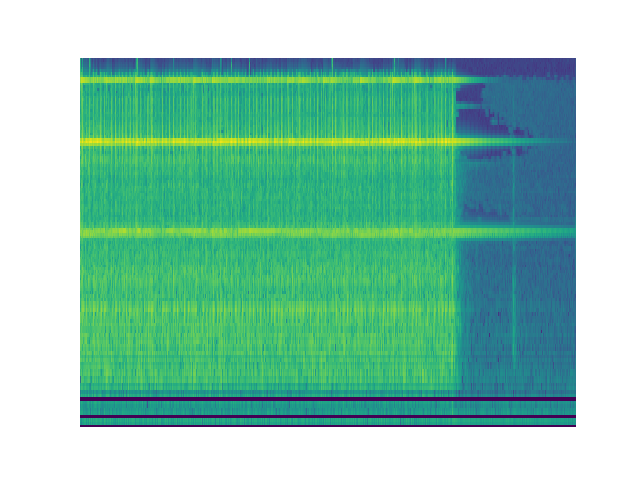

In [44]:
test_dls.dataset[0][0]

In [45]:
def get_activations(index):
    data = test_dls.dataset[index]
    img = data[0]
    
    with torch.no_grad(): 
        output = learn.predict(img)
    acts = np.array(hook_output.stored.cpu())[0]

    return list(acts)

The below computation takes a while.. We can rather load results computed earlier:

In [46]:
#test_df = pd.read_csv('data/esc50_with_cnn_activations.csv')

In [47]:
%%time
%%capture
test_df['activations'] = test_df['index'].apply(get_activations)

CPU times: user 2min 10s, sys: 1.44 s, total: 2min 11s
Wall time: 37 s


Now we've stored activations for each image:

In [48]:
test_df.head()

,index,filename,fold,target,category,esc10,src_file,take,Image,activations
0,1511,4-198841-A-37.wav,4,37,clock_alarm,False,198841,A,4-198841-A-37.png,"[4.0302477, 10.677426, -9.1083975, -2.0666034, 12.432157, -8.896985, 2.535248, -0.6131172, 3.7820613, 4.347226, 5.4647985, 9.227855, 11.433293, 4.2605996, 7.5115743, 1.2872097, 0.5735625, -3.2378087, -0.1153357, -2.1199448, -0.045295134, 3.4364946, -2.3806174, -4.483408, 2.8844025, 1.9763026, -2.4405236, 4.413552, -8.732527, 7.2259808, -1.061514, -1.5895758, 8.570769, -4.8732347, -4.360793, -9.626416, -6.691701, -10.854319, -4.2376366, -10.031569, 8.534706, -3.645884, -2.6107454, 11.692913, -8.247515, -1.9176708, -13.019351, 3.431575, 8.390834, -1.4343295, -4.4686737, -2.659144, -4.7352066..."
1,892,3-126358-B-3.wav,3,3,cow,False,126358,B,3-126358-B-3.png,"[-2.555739, -4.270952, -0.5574134, -0.48486862, 4.298602, -2.029224, 3.1829972, 13.032244, -0.78520143, 10.725936, 0.79996276, -0.9742322, 8.689372, -6.0158315, 10.631966, 7.418752, 2.4659998, 11.421068, -2.2701836, -4.5961523, 8.886691, -2.3878102, 3.102326, -0.6961085, 6.273204, 4.053729, 0.5788738, 1.8984147, 12.862285, 1.0127363, 9.558408, -3.26058, 1.9023772, 4.2033277, -2.408077, -0.6066527, 3.3892548, 5.1764402, -3.4117973, -2.5208168, -5.64097, -6.578484, 3.7457793, 2.6926215, -0.95605266, 5.4556317, 1.1678421, 2.9038608, -1.3138894, 7.572209, 6.891167, -2.6116664, 1.4349768, -0.42..."
2,1164,3-51909-A-42.wav,3,42,siren,False,51909,A,3-51909-A-42.png,"[-1.349528, -1.548904, 5.7906857, -1.5576808, 0.6298081, 3.4334316, 4.037396, 4.550182, 0.5540453, -3.122292, -3.0200114, -6.3462343, 1.7169338, -4.419726, 2.9712715, -0.073519945, 2.660464, 5.6427364, -10.142676, 3.5951052, 1.8174696, 2.171134, 1.6746156, -3.6194131, 6.7450314, -2.2178545, 4.0327244, 3.0391858, 6.6123824, 2.1993952, 0.7537496, -4.536458, 1.2106633, 6.478802, 3.3715684, 5.222677, -1.15102, 4.543665, -4.0517282, 0.22534081, -4.3219137, -5.58068, -3.7245266, -2.8092015, 4.465574, -2.13506, 5.4426208, 3.7768312, -1.7197546, 3.409172, -0.78242457, -4.9358716, 0.68759775, 8.947..."
3,1578,4-250869-A-2.wav,4,2,pig,False,250869,A,4-250869-A-2.png,"[-1.3713404, 3.9236941, -3.6748943, 10.558519, 7.695688, -7.8254466, -2.435677, -4.7373195, 3.579147, 5.7095866, 0.23790848, -5.8031173, 7.104426, 0.5972691, 5.458844, -5.700858, -7.242409, 9.62216, -0.60859185, -5.289054, -4.1336284, -2.045251, -7.6546974, 2.3756685, -8.107788, 6.1709523, 4.6462665, -0.16039422, -2.7084327, 4.669996, -2.4919722, -0.87511516, -1.50084, -1.398875, -0.2162315, -5.8899417, 0.35089236, -4.9753776, 15.020847, -2.2438269, 5.1153407, 1.379473, 6.5754066, 8.89219, -1.7727797, -2.4649954, -14.518359, -0.025162637, 11.1867485, -3.9081402, 0.036489904, 17.105545, -2...."
4,184,1-36164-B-26.wav,1,26,laughing,False,36164,B,1-36164-B-26.png,"[6.3591423, -0.44243142, -8.906721, -3.3593898, 5.5455666, 5.9883385, 0.85823333, -3.9531436, 2.4420865, -1.603766, -7.3575726, -0.9885918, -6.0525427, 9.258095, -0.57912946, 0.76979417, 4.441143, -1.7965683, -4.803292, -0.5965873, -2.483532, 3.0216475, 1.0141441, -0.1344233, -1.7199844, -1.4613947, -0.66544497, -3.2360072, -3.5212069, -5.928336, -7.704783, 2.3712862, -1.4301813, 1.9315867, 7.879536, -7.3512793, -1.2817153, 1.2650683, -2.3561552, -3.988614, -3.1142561, 2.1667163, -10.151194, -6.357018, -2.3340878, 5.95033, -0.5028018, -4.3233633, -1.3868626, -0.57018185, 1.8626382, -4.5623..."


We split the activations to have one column for each, as they can be treated as separate features later:

In [49]:
df_acts = pd.concat([test_df, pd.DataFrame(test_df.activations.values.tolist()).add_prefix('act_')], axis=1)

In [50]:
df_acts.drop('activations', axis=1, inplace=True)

Here's the result:

In [51]:
df_acts.head()

,index,filename,fold,target,category,esc10,src_file,take,Image,act_0,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,1511,4-198841-A-37.wav,4,37,clock_alarm,False,198841,A,4-198841-A-37.png,4.030248,...,-6.519384,3.146243,1.173895,0.173860,-3.951380,-1.262883,-3.894794,0.997374,5.535667,6.293305
1,892,3-126358-B-3.wav,3,3,cow,False,126358,B,3-126358-B-3.png,-2.555739,...,3.639894,9.968301,2.829005,3.497529,5.223256,1.398906,7.969010,3.871969,-0.647365,3.739807
2,1164,3-51909-A-42.wav,3,42,siren,False,51909,A,3-51909-A-42.png,-1.349528,...,10.443048,1.596953,-3.338792,-2.898744,10.772790,1.355639,4.263865,5.735000,0.643940,-3.239980
3,1578,4-250869-A-2.wav,4,2,pig,False,250869,A,4-250869-A-2.png,-1.371340,...,-4.637640,3.176324,-6.743503,13.363934,2.982634,2.848808,9.331854,-3.795128,7.606468,6.259652
4,184,1-36164-B-26.wav,1,26,laughing,False,36164,B,1-36164-B-26.png,6.359142,...,3.069320,-4.628930,3.079627,0.346388,3.939089,-3.363761,-3.621665,5.720055,-1.100827,8.397426


In [52]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 137 entries, index to act_127
dtypes: bool(1), float32(128), int64(4), object(4)
memory usage: 1.1+ MB


In [ ]:
df_acts.to_csv('data/esc50_with_cnn_activations.csv', index=None)

# Next: fuse with audio features

Next week, we'll discuss feature engineering in the context of time series. That will give us the tools we need to add audio features to the ones extracted using a CNN.